# Facility Location: MIP Problem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from mip_facility_location import utils, ortools_fl as ort_fl

## Problem modelling

$$ min \sum_{i=1}^{F} x_{i}f_{i} + \sum_{i=1}^{F}\sum_{j=1}^{C} y_{ij}c_{ij} $$
$$\text{where: }c_{ij} = \alpha d_{ij} $$
$$ d_{ij} \text{ :distance from facility i to customer j} $$
$$ \alpha \text{ cost factor applied to distance (e.g. €/km)} $$
$$s.t.$$
$$ x_{i} = \{0,1\} \forall i \in F$$
$$ y_{ij} = \{0,1\} \forall i \in F, j \in C$$
$$ \sum_{j=1}^{C}y_{ij}dem_{ij} <= x_{i}cap_{i} \forall i \in F \text{  (capacity-demand and matching)}$$
$$ \sum_{i=1}^{F} y_{ij} = 1 \forall j \in C \text{  (single supplier)}$$


# Input Data:
* Facilities: Location, Capacity, Fixed cost
* Customers: Location, Demand

In [3]:
file_path = "./mip_facility_location/data/fl_50_6"
input_data = utils.read_input_data(file_path)
facilities, facility_count, fac_location, fac_capacity, fac_fixed_cost, customers, customer_count, cust_location, cust_demand = utils.parse_data(input_data)


# EDA

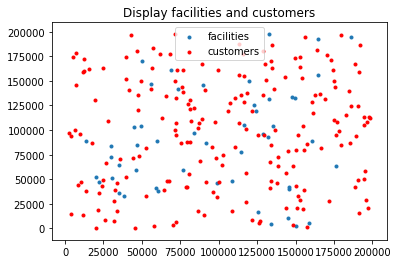

In [5]:
x,y = zip(*fac_location)
plt.scatter(x,y, marker=".", label="facilities")
x,y = zip(*cust_location)
plt.scatter(x,y, color="red",  marker=".", label="customers")
plt.title("Display facilities and customers")
plt.legend()
plt.show()

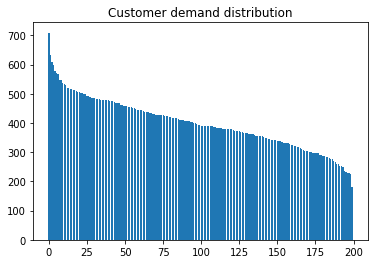

In [58]:
plt.bar(range(0, len(cust_demand)), sorted(cust_demand, reverse=True))
plt.title("Customer demand distribution")
plt.show()

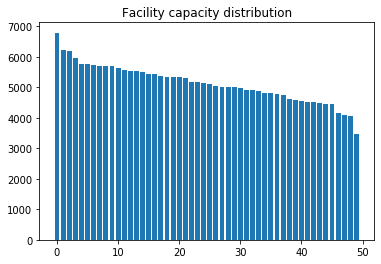

In [59]:
plt.bar(range(0, len(fac_capacity)), sorted(fac_capacity, reverse=True))
plt.title("Facility capacity distribution")
plt.show()

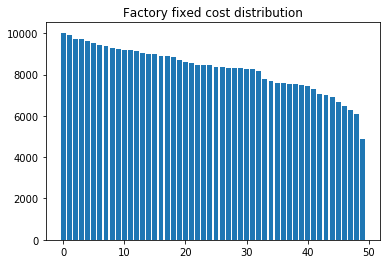

In [60]:
plt.bar(range(0, len(fac_fixed_cost)), sorted(fac_fixed_cost, reverse=True))
plt.title("Factory fixed cost distribution")
plt.show()

# Prepare model data

In [6]:
facilities_data = {}
facilities_data["location"] = fac_location
facilities_data["capacity"] = fac_capacity
facilities_data["fixed_cost"] = fac_fixed_cost
facilities_data["count"] = facility_count

customers_data = {}
customers_data["location"] = cust_location
customers_data["demand"] = cust_demand
customers_data["count"] = customer_count

In [10]:
dist_mat, capacities, fixed_cost, demand, fac_num, cust_num = utils.model_data(facilities_data, customers_data)

# Define model and solve

In [11]:
facility_closest_custs_n, cust_to_fac = utils.facility_to_cust_neighbour(dist_mat, facility_count, customer_count, int(facility_count/10))


In [12]:
model, _, dc_vars = ort_fl.model_sparse_partial(dist_mat, facility_closest_custs_n, cust_to_fac, capacities, fixed_cost, demand, fac_num,
                      1.0, 30)

Number of variables = 1050
Number of constraints = 250
Optimal!
Objective value = 3732793.4337715497


# Assess results

In [13]:
x = list(ort_fl.report_ortools_dc(dc_vars["x"], (fac_num)))
y = ort_fl.report_ortools_dc(dc_vars["y"], (fac_num, cust_num))

In [14]:
selected_fac = [idx for idx, fac in enumerate(x) if fac==1.0]

In [15]:
def get_selection_df():
    selection_list = []
    opened_list = []
    for idx_fac in selected_fac:
        customers = list(y[idx_fac,:])
        opened_list.append((idx_fac, fac_location[idx_fac][0], fac_location[idx_fac][1]))
        for idx_cust, customer in enumerate(customers):
            if customer == 1.0: 
                selection_list.append((idx_fac, idx_cust, cust_location[idx_cust][0], cust_location[idx_cust][1]))

    selection_df = pd.DataFrame(selection_list, columns=["fac_idx", "cust_idx","cust_x", "cust_y"])
    opened_df = pd.DataFrame(opened_list, columns=["fac_idx","fac_x", "fac_y"])
    return selection_df, opened_df

In [16]:
from matplotlib.pyplot import cm

def plot_solution(ax):
    grouped = selection_df.groupby('fac_idx')
    colours = cm.rainbow(np.linspace(0, 1, len(selected_fac)))

    colours_dict = {}
    for i, fac_idx in enumerate(selected_fac):
        colours_dict[fac_idx] = colours[i].reshape((1,-1))

   
    opened_df.plot.scatter(x="fac_x", y="fac_y", marker="*", s=100, color=colours, ax=ax)
    for key, group in grouped:
        group.plot.scatter(x="cust_x", y="cust_y", marker=".", s=50, color=colours_dict[key], ax=ax)
    return ax


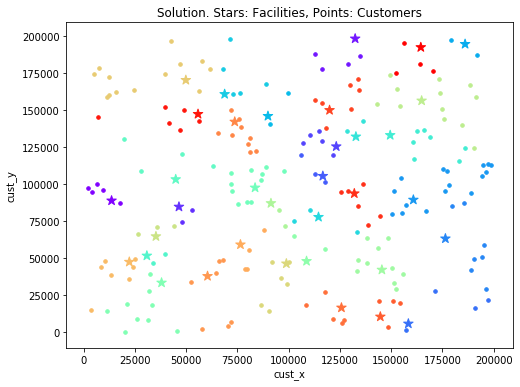

In [17]:
selection_df, opened_df = get_selection_df()

fig, ax = plt.subplots(figsize=(8,6))
sol_ax = plot_solution(ax)
sol_ax.set_title("Solution. Stars: Facilities, Points: Customers")
plt.show()

In [ ]:
fac_fixed_cost

In [64]:
fac_var_cost = (y*dist_mat).sum(axis=1)

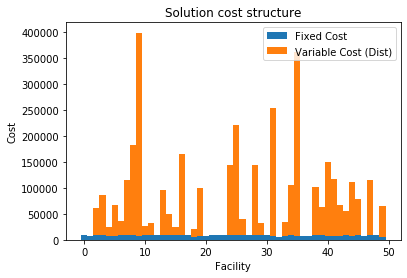

In [81]:
width = 1
ind = np.arange(0, fac_num)
plt.bar(ind, fac_fixed_cost, width, label='Fixed Cost')
plt.bar(ind, fac_var_cost, width, bottom=fac_fixed_cost, label='Variable Cost (Dist)')
plt.title("Solution cost structure")
plt.ylabel("Cost")
plt.xlabel("Facility")
plt.legend()
plt.show()

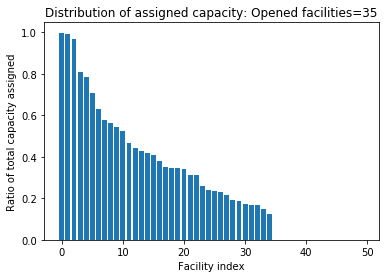

In [109]:
fig= plt.figure()
usage_factor = list((y*np.array(cust_demand)).sum(axis=1)/fac_capacity)
usage_factor.sort(reverse=True)
ax = plt.bar(ind, usage_factor)
plt.title(f"Distribution of assigned capacity: Opened facilities={int(sum(x))}")
plt.ylabel("Ratio of total capacity assigned")
plt.xlabel("Facility index")
plt.show()